# Music Generation with RNNs

##Carlos Bertomeu and Roger Caritj

We will explore building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in ABC notation and then use this model to generate new music. 

## Dependencies 
First, install dependencies, and import the relevant packages we'll need.

In [0]:
! git clone https://github.com/aamini/introtodeeplearning_labs.git
% cd introtodeeplearning_labs
! git pull
% cd ..

Cloning into 'introtodeeplearning_labs'...
remote: Enumerating objects: 1072, done.
remote: Total 1072 (delta 0), reused 0 (delta 0), pack-reused 1072
Receiving objects: 100% (1072/1072), 121.28 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (597/597), done.
/content/introtodeeplearning_labs
Already up to date.
/content


In [0]:
import tensorflow as tf 
import introtodeeplearning_labs as util
tf.enable_eager_execution()

import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay

is_correct_tf_version = '1.13.0' in tf.__version__
is_eager_enabled = tf.executing_eagerly()
!apt-get install abcmidi timidity > /dev/null 2>&1

## Dataset
We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. 

In [0]:
path_to_file = tf.keras.utils.get_file('irish.abc', 'https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/data/irish.abc')

212992/197618 [================================] - 0s 0us/step


### Inspect the dataset

We can take a look and listen to get a better sense of the dataset:

In [0]:
text = open(path_to_file).read()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 197618 characters


We can grab a song from our dataset as an example and play it back: 

In [0]:
util.play_generated_song(text)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Take a look at the first 500 characters in text
print(text[:500])

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!

X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:


One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. 

In [0]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

83 unique characters


<!-- TODO: here explanation of the one-hot encoding, getting the unique characters in the file -->

## Process the dataset for the learning task

We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (predict) a new piece of music based on this learned information. 

Given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
text_as_int = np.array([char2idx[c] for c in text])
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [0]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  '!' :   2,
  ' ' :   1,
  '#' :   4,
  '"' :   3,
  "'" :   5,
  ')' :   7,
  '(' :   6,
  '-' :   9,
  ',' :   8,
  '/' :  11,
  '.' :  10,
  '1' :  13,
  '0' :  12,
  '3' :  15,
  '2' :  14,
  '5' :  17,
  '4' :  16,
  '7' :  19,
  '6' :  18,
  ...
}


We can also look at how the first part of the text is mapped to an integer representation:

In [0]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'X:1\nT:Alexand' ---- characters mapped to int ---- > [49 22 13  0 45 22 26 67 60 79 56 69 59]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

First, use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices. This is a function within `tf.data` which is generally useful for importing data.

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)


Next, we need to define the input and target texts for each sequence. 

Define a function to do this, and then use the map method to apply a simple function to each batch. 

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the `RNN` considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [0]:
for input_example, target_example in dataset.take(1):
  
  for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
      print("Step {:4d}".format(i))
      print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
      print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Instructions for updating:
Colocations handled automatically by placer.
Step    0
  input: 49 ('X')
  expected output: 22 (':')
Step    1
  input: 22 (':')
  expected output: 13 ('1')
Step    2
  input: 13 ('1')
  expected output: 0 ('\n')
Step    3
  input: 0 ('\n')
  expected output: 45 ('T')
Step    4
  input: 45 ('T')
  expected output: 22 (':')


### Create training batches

Now we have our text split into sequences of manageable size. But before we actually feed this data into our model, we'll shuffle the data (for the purpose of stochastic gradient descent) and then pack it into batches which will be used during training.

In [0]:
# Batch size 
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size is similar to a queue size
# This defines a manageable data size to put into memory, where elements are shuffled
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Examine the dimensions of the dataset
dataset

<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## The Recurrent Neural Network (RNN) model

### Define the RNN model

Let's define some important dimensions:

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
embedding_dim = 256

# The number of RNN units
rnn_units = 1024

Now, we can define the function that will be used to actually build the model. 

In [0]:
if tf.test.is_gpu_available():
  LSTM = tf.keras.layers.CuDNNLSTM
else:
  LSTM = functools.partial(
    tf.keras.layers.LSTM, recurrent_activation='sigmoid')

LSTM = functools.partial(LSTM, 
  return_sequences=True, 
  recurrent_initializer='glorot_uniform',
  stateful=True
)

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    LSTM(rnn_units),
    tf.keras.layers.Dense(vocab_size) 
  ])

  return model

In [0]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)


### Test out the RNN model

We used the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           21248     
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (64, None, 1024)          5251072   
_________________________________________________________________
dense (Dense)                (64, None, 83)            85075     
Total params: 5,357,395
Trainable params: 5,357,395
Non-trainable params: 0
_________________________________________________________________


We can check the dimensionality of our output, using a sequence length of 100.

In [0]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(TensorShape([Dimension(64), Dimension(100), Dimension(83)]), '# (batch_size, sequence_length, vocab_size)')


### Predictions from the untrained model

To get predictions from the model, we sample from the output distribution, which is defined by a softmax over our character vocabulary. This will give us actual character indices.

Let's  sample out for the first example in the batch.

In [0]:
sampled_indices = tf.random.multinomial(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

Instructions for updating:
Use tf.random.categorical instead.


In [0]:
sampled_indices

array([10, 20, 58, 41, 10, 73,  2, 82, 80, 49, 26, 47, 35, 31,  8, 35,  6,
       10, 27, 74, 54, 69,  2,  6, 15, 67, 52, 29, 41, 76, 72, 70, 40, 40,
       74, 19, 69, 26, 18, 21, 54, 48, 18, 67, 35, 16, 52,  4, 66, 16, 43,
       68, 46, 11, 19, 67, 25, 10, 36, 32, 73, 61, 76,  1, 42, 12, 46, 51,
       67, 76, 45, 45, 31,  7, 34, 76, 46, 28,  5, 74, 73, 58, 54, 12, 50,
       32, 73, 32, 15, 54,  6, 81, 71,  2, 17, 49, 25, 49,  6,  6])

We can now decode these to see the text predicted by the untrained model:

In [0]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

('Input: \n', "'id:dc-reel-68\\nM:C\\nL:1/8\\nK:A Dorian\\nG|EAAB cBcG|EGG2 EGDG|EAAB cBce|dBgB BAA:|!\\nB|c2ec gcec|c2ec dBGB'")
()
('Next Char Predictions: \n', '".8cP.r!|yXAVJF,J(.Bs^n!(3l[DPuqoOOs7nA69^W6lJ4[#k4RmU/7l>.KGrfu Q0UZluTTF)IuUC\'src^0YGrG3^(zp!5X>X(("')


The untrained model make no sense! Let's train!

### Training the model: loss and training operations

We have the previous state of the RNN as well as the input at a given time step, and want to predict the class of the next character, that is, actually predict the next character. So, to train our model on this classification task, we can use a form of the `crossentropy` loss. We will want to compute the loss using the true targets and the predicted targets.

Let's first compute the loss using our example predictions from the untrained model: 

In [0]:
def compute_loss(labels, logits):
  return tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = compute_loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

('Prediction shape: ', TensorShape([Dimension(64), Dimension(100), Dimension(83)]), ' # (batch_size, sequence_length, vocab_size)')
('scalar_loss:      ', 4.419252)


We will use the tf.GradientTape method to perform the backpropagation operations. 

We will generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss!

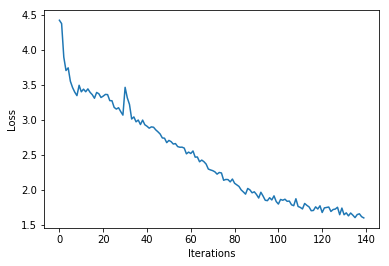

N/A%|#                                              |Time:  0:00:02  Loss: 1.59


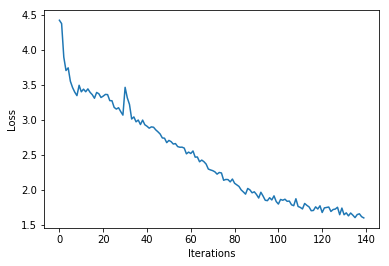

In [0]:
# Training step
EPOCHS = 5 
optimizer = tf.train.AdamOptimizer() # TODO
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

history = []
plotter = util.PeriodicPlotter(sec=1, xlabel='Iterations', ylabel='Loss')
for epoch in range(EPOCHS):

    # Initialize the hidden state at the start of every epoch; initially is None
    hidden = model.reset_states()
    
    # Enumerate the dataset for use in training
    custom_msg = util.custom_progress_text("Loss: %(loss)2.2f")
    bar = util.create_progress_bar(custom_msg)
    for inp, target in bar(dataset):
        # Use tf.GradientTape()
        with tf.GradientTape() as tape:
            predictions = model(inp)
            loss = compute_loss(target, predictions)
        
        # Now, compute the gradients and try to minimize
        grads = tape.gradient(loss, model.trainable_variables) # TODO
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Update the progress bar!
        history.append(loss.numpy().mean())
        custom_msg.update_mapping(loss=history[-1])
        plotter.plot(history)
    
    # Update the model with the changed weights!
    model.save_weights(checkpoint_prefix.format(epoch=epoch))



## Generate music using the RNN model

When generating music, we'll have to feed the model some seed to get it started. Once we have it, we can then iteratively predict each successive character using our trained RNN. More specifically, recall that our RNN outputs a softmax over possible successive caharacters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (1, None, 1024)           5251072   
_________________________________________________________________
dense_1 (Dense)              (1, None, 83)             85075     
Total params: 5,357,395
Trainable params: 5,357,395
Non-trainable params: 0
_________________________________________________________________


In [0]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  bar = util.create_progress_bar()
  for i in bar(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy() # TODO 
      
      # Pass the prediction along with the previous hidden state
          # as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id]) # TODO 

  return (start_string + ''.join(text_generated))

In [0]:
# Different characters outputs different results, let's try G
text = generate_text(model, start_string="G")

100%|#########################################################|Time:  0:00:04  


### Play the generated music!

With this function we can convert the ABC format text to an audio file, and then play that back to check out our generated music!

In [0]:
util.play_generated_song(text)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print(text)

G<g,2DG: deegf|gafg gddB|!
a3|a3a|efef cce|]
bag aed|cA cAB|BGEG AFE|FB,EC|EDCB,C/F,M,G>E,EC|DED E2F|FDF FBe|!
efa g2A|BFA E2rA|GBG GBA|gB/A F3|!
efg fdg|fgg fed|eaa e3|g2a agf|a3 ge|!
a2 M:A|!
g|!4
Z:17
T:Cahhes isoigo
Z: id:dc-3)eild-35
M:6/8
L:1/8
K:A Mixol
anlin
a2e|fef edA|ABA AdA|dcA AEA|^GG, AFD|!
BAB gef|afg a2:|!
a
Z:75
T:Summg naitey
Z: id:dc-seedrf2|e2be abge|b2abgs|fage dGBA|!
B=d,B AGA|G2A ACA|G3 D2|fd f2 g3|!
A>B d2|a4 eAB FAF|AdB B2E|GGB F2:|!

X:17
T:Fk Dorifas
o K:vigrlran
Z: id:c-dec-118
M:6/8
L:1/8
K:A Mxxoan
A|F2E FE2|Bd Bdd|egf agf|d2dc dBdf|agaf edB|!
defld e3rjiaA|
ABA EEe|cABA FEd2|B3G dBdA|!
DGFG FDEB cBBG|BdBc d2gf|ABdd eAdB|cAFB d2:|!
fef e3f|fgeg|^eag fga|fbb bece|efef g2:^c-27
M:C
L:1/8
K: Mori
dB|A2FA FAAA|FEA2 BdA2|AcA2 c2ec|dedc GED:|!

X:242
:Ous ticmpssmeln
Z:iidede-ieln3 M:2|!
G2BG GFGG|A2Bc AGDG|GEEE G2:|!
df|fge gdB|BFA dcd|AFF EED|BBA Bcf|bfg e2:|!

X:29
TT:eltro iard|FFd cAE|EnD EEF/E,A GAB|(EFEE GGBd|(
A2Bd BAGB|dBGB G2FA|fAAF EGEE|D3|!
A2B|fge B